In [5]:
import os
import sys
import random
import cv2
import math
import time
import numpy as np
import re
import glob
import pandas as pd
from skimage.io import imsave
from multiprocessing import Pool

ROOT_DIR = os.path.abspath('../models/Mask_RCNN')
DATA_DIR = '../data'
#import mask rcnn
sys.path.append(ROOT_DIR)

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn.model import log

from mask_rcnn_config import SegmentationConfig
from mask_rcnn_config import SegmentationDataset

MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [8]:
from sklearn import model_selection
import matplotlib
import matplotlib.pyplot as plt
from mrcnn import visualize
import scipy.misc
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [10]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [12]:
train = glob.glob(DATA_DIR+'/train_color/*.jpg')
test = glob.glob(DATA_DIR+'/test/*.jpg')
X_train, X_val, _, _ = model_selection.train_test_split(train, train, test_size=0.3)
config = SegmentationConfig()
config.display()
dataset_train = SegmentationDataset()
dataset_train.load_cvpr_images(X_train)
dataset_train.prepare()

dataset_val = SegmentationDataset()
dataset_val.load_cvpr_images(X_val)
dataset_val.prepare()

testset = SegmentationDataset()
testset.load_cvpr_images(test)
testset.prepare()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                22
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9

In [13]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=15, 
            layers='heads')

### Inference

In [14]:
class InferenceConfig(SegmentationConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /Users/ram/Documents/moises/proyectos/labs/ml/mix/cvpr_2018_segmentation_wad/models/Mask_RCNN/logs/segmentationconfig20180530T2312/mask_rcnn_segmentationconfig_0015.h5


In [15]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (22,)                 min:    0.00000  max: 11338.00000  float64
gt_class_id              shape: (2,)                  min:    7.00000  max:    9.00000  int32
gt_bbox                  shape: (2, 4)                min:  466.00000  max:  676.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  bool


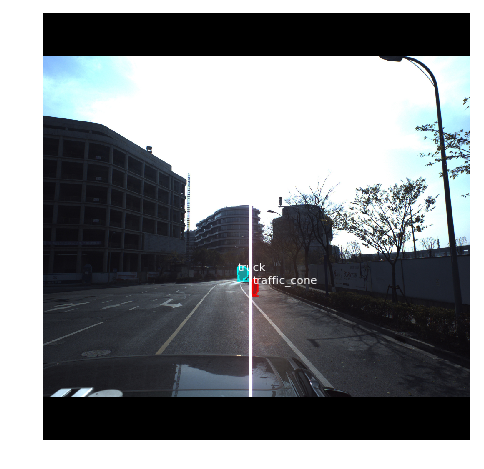

In [16]:
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

### Predict

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


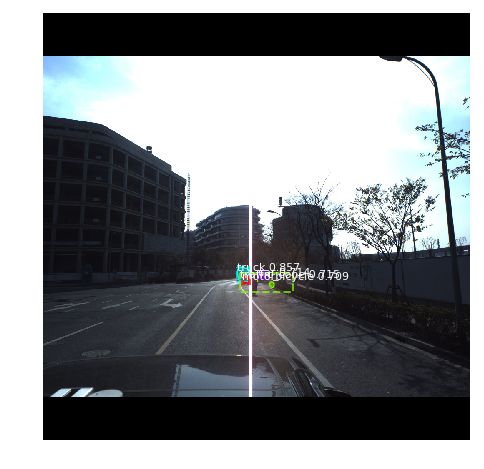

In [17]:
results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
r['rois']

In [ ]:
plt.imshow(original_image[711:883,763:1020, :])

In [ ]:
plt.imshow(r['masks'][:, :, 1][711:883,763:1020])

In [ ]:
len(testset.image_ids)

### Getting the test data results

In [3]:

pool = Pool(processes=8)


In [2]:
def find_pixels(mask):
    endcoded_pixels = []
    total_pixels = 0
    for i in range(mask.shape[0]):
        init = 0
        end = 0
        carry = i*mask.shape[1]
        for j in range(1, mask.shape[1]):
            if mask[i, j] > 0 and mask[i, j - 1] == 0:
                init = j + carry

            if mask[i, j] == 0 and mask[i, j - 1] > 0:
                end = j-init + carry
                endcoded_pixels.append( str(init) + ' ' +  str(end) ) 
                total_pixels += end
                init = 0
                end = 0

    return endcoded_pixels, total_pixels

In [ ]:
def process_result(r, image_name, image_id):
    data = []
    for i in range(len(r['scores'])):
        mask_idx = i
        confidence = r['scores'][i]
        label_id = r['class_ids'][i]
        mask = r['masks'][:, :, i]
        rois = r['rois'][i]

        data_point = {}
        old_id = testset.CLASS_ID_TO_NAME[label_id]['old_id']
        mask_name = DATA_DIR+'/test_masks/'+ image_name + '_' + str(mask_idx) +'.jpg'
        imsave(mask_name, mask)

        data_point['ImageId'] = image_name
        data_point['LabelId'] = old_id
        data_point['Confidence'] = confidence
        data_point['PixelCount'] = 0
        data_point['rois'] = rois
        data_point['EncodedPixels'] = mask_name

        data.append(data_point)

    return data

In [ ]:
test_results = []
jobs = []
t3 = time.time()
for test_id in testset.image_ids:
    if (test_id % 50) == 0:
        print(test_id)
    results = model.detect([testset.load_image(test_id)], verbose=0)
    r = results[0]

    image_name = testset.image_info[test_id]['image_name']

    p_result = pool.apply_async(process_result, (r, image_name, test_id) )
    jobs.append(p_result)

for job in jobs:
    p_result = job.get(timeout=20)
    test_results = test_results + p_result
t3_ = time.time()
print("Time for all takes:", t3_ - t3)

In [ ]:
print(len(test_results) )
test_results[-1]

In [ ]:
# df_test_results = pd.DataFrame(test_results)

In [ ]:
df_test_results = pd.read_csv(DATA_DIR+'/test_results.csv')
df_test_results.head()

In [ ]:
columns = ['ImageId','LabelId','PixelCount','Confidence','EncodedPixels']

In [ ]:
df_test_results.to_csv(DATA_DIR+'/submit_test_.csv',index=False, columns=columns)

In [ ]:
a=cv2.imread(DATA_DIR+'/test_masks/4e3c95fe41cce1072ccbb69e8a1a20fb_4.jpg')

In [ ]:
a.sum()

In [ ]:
plt.imshow(a*255)

In [ ]:
r['masks'][:, :, 0].shape

In [ ]:

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

In [ ]:
r["rois"]

In [ ]:
r["class_ids"]

In [ ]:
r["scores"]

In [ ]:
r

#### Submision File


In [ ]:
d = df_test_results.ix[200]
d

In [ ]:
mask_path = d['EncodedPixels'].split('/')[-1]
mask_im = cv2.imread(DATA_DIR+'/test_masks/'+mask_path, cv2.IMREAD_UNCHANGED)

In [ ]:
mask_bound = [ int(x) for x in d.rois.replace("[", "").replace("]", "").split() ]
mask = mask_im[mask_bound[0]:mask_bound[2], mask_bound[1]:mask_bound[3]]

In [ ]:
plt.imshow(mask*255)
mask.shape

In [ ]:
encodp, _ = find_pixels(mask)

In [ ]:
"|".join(encodp) + "|"

In [4]:
df_test_results = pd.read_csv("/Users/ram/Downloads/test_results.csv")
df_test_results['EncodedPixels_'] = df_test_results['EncodedPixels']
df_test_results['PixelCount'][3]
df_test_results.shape

(20328, 7)

In [ ]:
# for i in range(2):
for i in range(df_test_results.shape[0]):
    d = df_test_results.ix[i]
    mask_path = d['EncodedPixels'].split('/')[-1]
    mask_im = cv2.imread(DATA_DIR+'/test_masks/'+mask_path, cv2.IMREAD_UNCHANGED)
    mask_bound = [ int(x) for x in d.rois.replace("[", "").replace("]", "").split() ]
    mask = mask_im[mask_bound[0]:mask_bound[2], mask_bound[1]:mask_bound[3]]
    encoded_pixels, pixels_count = find_pixels(mask)
    encoded_pixels = "|".join(encoded_pixels) + "|"
    df_test_results['PixelCount'][i] = pixels_count
    df_test_results['EncodedPixels'][i] = encoded_pixels

In [ ]:
df_test_results.head()

In [5]:
#initialize the csv header
with open('my_csv.csv', 'a') as f:
    f.write('ImageId,LabelId,Confidence,PixelCount,EncodedPixels,mask_file')
    f.write('\n')
    
#abstract the function
def result_function(i):
    d = df_test_results.iloc[i]
    mask_path = d['EncodedPixels'].split('/')[-1]
    mask_im = cv2.imread(DATA_DIR+'/test_masks/'+mask_path, cv2.IMREAD_UNCHANGED)
    mask_bound = [ int(x) for x in d.rois.replace("[", "").replace("]", "").split() ]
    mask = mask_im[mask_bound[0]:mask_bound[2], mask_bound[1]:mask_bound[3]]
    encoded_pixels, pixels_count = find_pixels(mask)
    encoded_pixels = "|".join(encoded_pixels) + "|"
    mask_file = d['EncodedPixels']
#     df_test_results['PixelCount'][i] = pixels_count
#     df_test_results['EncodedPixels'][i] = encoded_pixels
#     print(df_test_results.ix[i])
    with open('my_csv.csv', 'a') as f:
        #df_test_results.ix[i].to_csv(f, header=False)
        #pd.DataFrame(df_test_results.iloc[i]).to_csv(f, header=False)
        f.write(str(i) + ',' + str(df_test_results.iloc[i]['ImageId']) + ',' + str(df_test_results.iloc[i]['LabelId']) + ',' + str(df_test_results.iloc[i]['Confidence']) + ',' + str(pixels_count) + ',' + str(encoded_pixels) + ',' + mask_file )
        f.write('\n')

In [9]:
pool = Pool(8)
zip(pool.map(result_function, range(0, df_test_results.shape[0])))
pool.close()

In [18]:
new_r = pd.read_csv("/Users/ram/Downloads/new_results.csv")
test_r = pd.read_csv("/Users/ram/Downloads/test_results.csv")

In [6]:
new_r["PixelCount"].max()

3414205200

In [20]:
test_r["EncodedPixels"][0]

'/home/ubuntu/datalab/test_masks/56dbd8514bd2b8d1566f8977cfeb0406_0.jpg'

In [22]:
test_r.shape

(20328, 6)

In [23]:
new_r.shape

(19285, 5)